<a href="https://colab.research.google.com/github/smagara/LangGraph-Coursework/blob/main/langgraph_react_agent_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continue LangGraph course

# ReAct Agent with Tools example

1.   Create Tools in LangGraph
2.   Learn to create a ReAct Graph, an agent that reacts to feedback
3.   Handle sending and handling different types of messages, now ToolMessages
4.   Test for robustnestness

Main Goal: Create a robust Graph

START -> Agent <--> Tools (continue) -> End

---

In [1]:
## installs
%pip install -U langgraph
%pip install -U langchain-openai
%pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 2.2 MB/s eta 0:00:00


In [9]:
## Setup imports
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from google.colab import userdata
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages


In [3]:
## Color codes for more interesting markdown output
magenta_color_code = "\033[95m"
green_color_code = "\033[32m"
blue_color_code = "\033[34m"
red_color_code = "\033[91m"
reset_color_code = "\033[0m"

def set_print_color(color_code):
    print(color_code)

def reset_print_color():
    print(reset_color_code)

In [4]:
def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)
    else:
      message.pretty_print()

In [5]:
# Integrate an AI LLM
load_dotenv()
openAIkey = userdata.get('OPENAI_API_KEY')
model = ChatOpenAI(model_name="gpt-4o", openai_api_key=openAIkey)


In [6]:
## use our aggregator to collect messages by adding them to the collection automatically
class AgentState(TypedDict):
   messages: Annotated[Sequence[BaseMessage], add_messages]

In [27]:
## Tools

@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""
    return a + b

@tool
def subtract(a: int, b:int):
    """This is an subtraction function that returns the difference between the input numbers"""
    return a - b


@tool
def mult(a: int, b:int):
    """This is an multiplication function that multiplies the input"""
    return a * b

tools = [add, subtract, mult]
model = model.bind_tools(tools)

In [28]:
## Nodes
def model_call(state:AgentState) -> AgentState:
  system_prompt = SystemMessage(content="You are a helpful assistant, please answer my query to the best of your ability.")
  print([system_prompt] + state["messages"])
  response = model.invoke([system_prompt] + state["messages"])
  return {"messages" : [response]}

In [29]:
## Conditional edge logic
def should_continue(state: AgentState):
  messages = state["messages"]
  last_message = messages[-1]
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [30]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)

graph.add_edge("tools", "our_agent")

app=graph.compile()

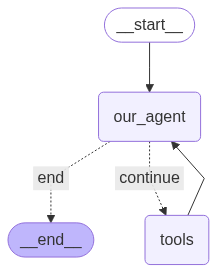

In [31]:
## show the state graph
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
## LangGraph should call the tool(s) or answer from its LLM if none are applicable.
inputs = {"messages" : [("user", "Add 34 + 21.  Then multiply 12 by 22.  Also subtract 23 from 88 then tell a joke")]}
print_stream(app.stream(inputs, stream_mode = "values"))


================================ Human Message =================================

Add 34 + 21.  Then multiply 12 by 22.  Also subtract 23 from 88 then tell a joke
[SystemMessage(content='You are a helpful assistant, please answer my query to the best of your ability.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Add 34 + 21.  Then multiply 12 by 22.  Also subtract 23 from 88 then tell a joke', additional_kwargs={}, response_metadata={}, id='8643d3fc-a28e-436d-bb78-20f8e6816437')]
================================== Ai Message ==================================
Tool Calls:
  add (call_zhwSz1RkF5JRHyqoYy7rkTet)
 Call ID: call_zhwSz1RkF5JRHyqoYy7rkTet
  Args:
    a: 34
    b: 21
  mult (call_PAF5QD87CHrQhXqsFLSKl6Sj)
 Call ID: call_PAF5QD87CHrQhXqsFLSKl6Sj
  Args:
    a: 12
    b: 22
  subtract (call_mM4qdvb3H3g8Wys83uwvYVBT)
 Call ID: call_mM4qdvb3H3g8Wys83uwvYVBT
  Args:
    a: 88
    b: 23
================================= Tool Message ============================

In [ ]:
inputs = {"messages" : [("user", "Divide 3 by 4.")]}
print_stream(app.stream(inputs, stream_mode = "values"))